{% include toc title="In This Chapter" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Chapter Nine - Landsat Data in Open Source Python

In this chapter, you will learn how to work with Landsat multi-band raster data stored in `.tif` format in **Python** using **rioxarray**.

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this chapter, you will be able to:

* Use `glob()` to create a subsetted list of file names within a specified directory on your computer.
* Create a raster stack from a list of `.tif` files in **Python**.
* Crop rasters to a desired extent in **Python**.
* Plot various band combinations using a numpy array in **Python**.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson and the Cold Springs Fire data.

{% include /data_subsets/course_earth_analytics/_data-cold-springs-fire.md %}

</div>


In the <a href="http://localhost:4000/courses/use-data-open-source-python/multispectral-remote-sensing/intro-naip/" target="_blank">NAIP data chapter in this textbook,</a> you learned how to 
import a multi-band image into **Python** using
**rioxarray**. You then plotted the data as a composite, 
RGB (and CIR) image using `imshow()` and calculated NDVI. 

In that case, all bands of the data were stored in a single `.tif` file. 
However, sometimes data are downloaded in individual bands rather than a single file.

In this chapter, you will learn how to work with Landsat data in **Python**. 
Each band in a landsat scene is often stored in an individual `.tif` file. 
Thus you will need to grab the bands that you want to work with and then bring 
them into a `xarrray` DataFrame. 


## About Landsat Data

> At over 40 years, the Landsat series of satellites provides the longest temporal record of moderate resolution multispectral data of the Earth’s surface on a global basis. The Landsat record has remained remarkably unbroken, proving a unique resource to assist a broad range of specialists in managing the world’s food, water, forests, and other natural resources for a growing world population.  It is a record unmatched in quality, detail, coverage, and value. Source: <a href="https://www.usgs.gov/land-resources/nli/landsat/about?qt-science_support_page_related_con=2#qt-science_support_page_related_con" target="_blank">USGS</a>


<figure>
    <a href="{{ site.url }}/images/earth-analytics/remote-sensing/timeline-only-for-webRGB.png">
    <img src="{{ site.url }}/images/earth-analytics/remote-sensing/timeline-only-for-webRGB.png" alt="Landsat 40 year timeline source: USGS.">
    </a>
    <figcaption>The 40 year history of landsat missions. Source: USGS - <a href="https://www.usgs.gov/land-resources/nli/landsat/landsat-satellite-missions?qt-science_support_page_related_con=2#qt-science_support_page_related_con" target = "_blank">USGS Landsat Timeline</a>
    </figcaption>
</figure>

Landsat data are spectral and collected using a platform mounted on a satellite in space that orbits the earth. The spectral bands
and associated spatial resolution of the first 9 bands in the Landsat 8 sensor
are listed below.

#### Landsat 8 Bands

| Band | Wavelength range (nanometers) | Spatial Resolution (m) | Spectral Width (nm)| Units | Data Type | Fill Value (no data) |  Range |Valid Range | Scale Factor |
|-------------------------------------|------------------|--------------------|----------------|----------------|----------------|----------------|---------------------| ----------------|----------------|
| Band 1 - Coastal aerosol | 430 - 450 | 30 | 2.0 | Reflectance | 16-bit signed integer (int16) | -9999 | -2000 to 16000 |0 to 10000 | 0.0001 |
| Band 2 - Blue | 450 - 510 | 30 | 6.0 |  Reflectance | 16-bit signed integer (int16) | -9999 | -2000 to 16000 |0 to 10000 | 0.0001 |
| Band 3 - Green | 530 - 590 | 30 | 6.0 |  Reflectance | 16-bit signed integer (int16) | -9999 | -2000 to 16000 |0 to 10000 | 0.0001 |
| Band 4 - Red | 640 - 670 | 30 | 0.03 |  Reflectance | 16-bit signed integer (int16) | -9999 | -2000 to 16000 |0 to 10000 | 0.0001 |
| Band 5 - Near Infrared (NIR) | 850 - 880 | 30 | 3.0 |  Reflectance | 16-bit signed integer (int16) | -9999 | -2000 to 16000 |0 to 10000 | 0.0001 |
| Band 6 - SWIR 1 | 1570 - 1650 | 30 | 8.0  |  Reflectance | 16-bit signed integer (int16) | -9999 | -2000 to 16000 |0 to 10000 | 0.0001 |
| Band 7 - SWIR 2 | 2110 - 2290 | 30 | 18 |  Reflectance | 16-bit signed integer (int16) | -9999 | -2000 to 16000 |0 to 10000 | 0.0001 |

Review the <a href="https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf" target="_blank">Landsat 8 Surface Reflectance Product Guide</a> for more details.

There are additional collected bands that are not distributed within the Landsat 8 Surface Reflectance Product such as the panchromatic band, which provides a finer resolution, gray scale image of the landscape, and the cirrus cloud band, which is used in the quality assessment process:


| Band | Wavelength range (nanometers) | Spatial Resolution (m) | Spectral Width (nm)|
|-------------------------------------|------------------|--------------------|----------------|
| Band 8 - Panchromatic | 500 - 680 | 15 | 18 |  
| Band 9 - Cirrus | 1360 - 1380 | 30 | 2.0 |  


### Understand Landsat Data

When working with landsat, it is important to understand both the metadata and
the file naming convention. The metadata tell you how the data were processed,
where the data are from and how they are structured.

The file names, tell you what sensor collected the data, the date the data were collected, and more.

<figure>
    <a href="{{ site.url }}/images/earth-analytics/remote-sensing/collection-filename-diffs.png">
    <img src="{{ site.url }}/images/earth-analytics/remote-sensing/collection-filename-diffs.png" alt="landsat file naming convention">
    </a>
    <figcaption>Landsat file names Source: USGS Landsat - <a href="https://www.usgs.gov/faqs/what-naming-convention-landsat-collections-level-1-scenes?qt-news_science_products=0#qt-news_science_products" target = "_blank">Landsat Scene Naming Conventions</a>
    </figcaption>
</figure>

### Landsat File Naming Convention

Landsat and many other satellite remote sensing data is named in a way that tells you a about:

* When the data were collected and processed
* What sensor was used to collect the data
* What satellite was used to collect the data.

And more. 

Here you will learn a few key components of the landsat 8 collection file name. The first scene that you work with below is named:

`LC080340322016072301T1-SC20180214145802`

First, we have LC08

* **L:** Landsat Sensor
* **C:** OLI / TIRS combined platform
* **08:** Landsat 8 (not 7)

* **034032:** The next 6 digits represent the path and row of the scene. This identifies the spatial coverage of the scene

Finally, you have a date. In your case as follows:

* **20160723:** representing the year, month and day that the data were collected.

The second part of the file name above tells you more about when the data were last processed. You can read more about this naming convention using the link below.

<a href="https://www.usgs.gov/faqs/what-naming-convention-landsat-collections-level-1-scenes?qt-news_science_products=0#qt-news_science_products" target="_blank">Learn more about Landsat 8 file naming conventions.</a>

As you work with these data, it is good to double check that you are working with the sensor (Landsat 8) and the time period that you intend. Having this information in the file name makes it easier to keep track of this as you process your data. 

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Download data and set working directory
data = et.data.get_data("cold-springs-fire")
os.chdir(os.path.join(et.io.HOME, 
                      "earth-analytics", 
                      "data"))

In [2]:
# Get list of all pre-cropped data and sort the data

# Create the path to your data
landsat_post_fire_path = os.path.join("cold-springs-fire",
                                      "landsat_collect",
                                      "LC080340322016072301T1-SC20180214145802",
                                      "crop")

# Generate a list of jtif files
post_fire_tifs_list = glob(os.path.join(landsat_post_fire_path,
                                        "*band*.tif"))

# Sort the data to ensure bands are in the correct order
post_fire_tifs_list.sort()
post_fire_tifs_list

['cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop.tif']

In [3]:
# # This will create a new stacked raster with all bands
# landsat_post_fire_arr, land_meta = es.stack(post_fire_tifs_list,
#                                             landsat_post_fire_path)

In [4]:
# Create an output array of all the landsat data stacked
landsat_post_fire_path = os.path.join("cold-springs-fire",
                                      "outputs",
                                      "landsat_post_fire.tif")

Below is a function to open and concatenate or combine a list of 
tif files into a final xarray object. The function will be 
explained in more detail in the following lessons.
    

In [5]:
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr=[]
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"]=i+1
     
    return xr.concat(out_xr, dim="band") 

In [6]:
# Open all bands
landsat_post_fire_xr = combine_tifs(post_fire_tifs_list)
landsat_post_fire_xr

<xarray.DataArray (band: 7, y: 177, x: 246)>
array([[[ 446.,  476.,  487., ...,  162.,  220.,  260.],
        [ 393.,  457.,  488., ...,  200.,  235.,  296.],
        [ 364.,  393.,  388., ...,  246.,  298.,  347.],
        ...,
        [ 249.,  283.,  363., ...,  272.,  268.,  284.],
        [ 541.,  474.,  364., ...,  260.,  269.,  285.],
        [ 219.,  177.,  250., ...,  271.,  271.,  286.]],

       [[ 515.,  547.,  572., ...,  181.,  233.,  261.],
        [ 440.,  519.,  571., ...,  211.,  251.,  322.],
        [ 411.,  460.,  449., ...,  264.,  326.,  387.],
        ...,
        [ 387.,  326.,  427., ...,  288.,  278.,  301.],
        [ 554.,  654.,  433., ...,  276.,  276.,  293.],
        [ 291.,  174.,  291., ...,  292.,  290.,  304.]],

       [[ 782.,  772.,  843., ...,  335.,  390.,  411.],
        [ 684.,  771.,  836., ...,  363.,  412.,  511.],
        [ 656.,  725.,  706., ...,  425.,  518.,  599.],
        ...,
...
        ...,
        [1900., 1917., 2076., ..., 1722., 1891., 1890.],
        [1779., 1893., 1983., ..., 1645., 1847., 2090.],
        [1553., 1440., 1587., ..., 1562., 1689., 1964.]],

       [[2864., 2974., 3108., ...,  983., 1195., 1271.],
        [2527., 2827., 3008., ..., 1132., 1293., 1546.],
        [2141., 2427., 2433., ..., 1324., 1652., 1922.],
        ...,
        [1662., 1757., 1922., ..., 1463., 1472., 1519.],
        [1786., 1532., 1554., ..., 1374., 1423., 1450.],
        [1071.,  943.,  975., ..., 1524., 1461., 1518.]],

       [[1920., 1979., 2098., ...,  537.,  660.,  687.],
        [1505., 1863., 1975., ...,  651.,  747.,  924.],
        [1240., 1407., 1391., ...,  769., 1018., 1189.],
        ...,
        [1216., 1190., 1398., ...,  877.,  890.,  928.],
        [1517., 1184., 1078., ...,  846.,  810.,  820.],
        [ 660.,  593.,  623., ...,  984.,  909.,  880.]]])
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * band         (band) int64 1 2 3 4 5 6 7
Attributes:
    STATISTICS_MAXIMUM:  3483
    STATISTICS_MEAN:     297.16466859584
    STATISTICS_MINIMUM:  -57
    STATISTICS_STDDEV:   119.61370418167
    scale_factor:        1.0
    add_offset:          0.0
    grid_mapping:        spatial_ref

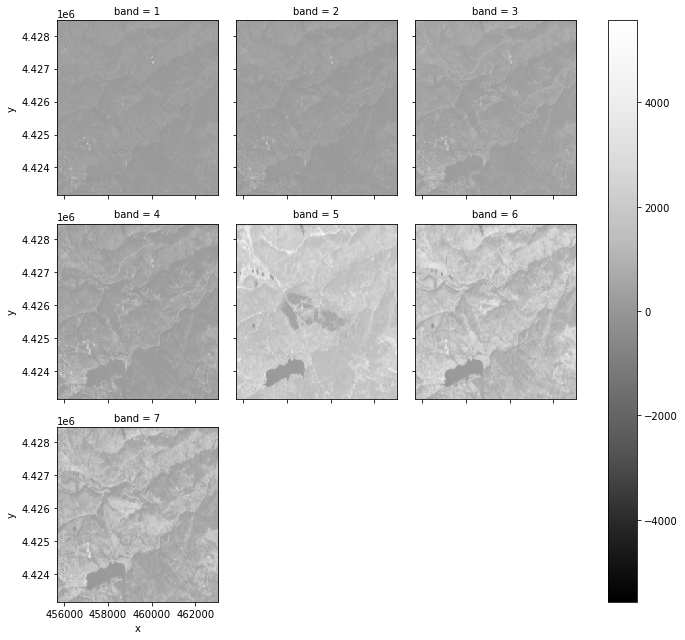

In [7]:
landsat_post_fire_xr.plot.imshow(col="band",
                                 col_wrap=3,
                                 cmap="Greys_r")
plt.show()

## Plot RGB image

Just like you did with NAIP data, you can plot 3 band color composite images 
for Landsat using the **earthpy** `ep.plot_rgb()` function. Refer to the 
landsat bands in the table at the top of this page to figure out the red, 
green and blue bands. Or read the
<a href="https://blogs.esri.com/esri/arcgis/2013/07/24/band-combinations-for-landsat-8/" target="_blank">ESRI landsat 8 band combinations</a> post.

`ep.plot_rgb()` requires:

1. the numpy array containing the bands that you wish to plot. You can access this by using `xarray_name.values`
IMPORTANT: this array should be in xarray band order (bands first). 

2. The numeric location of bands that you wish to plot in the array.


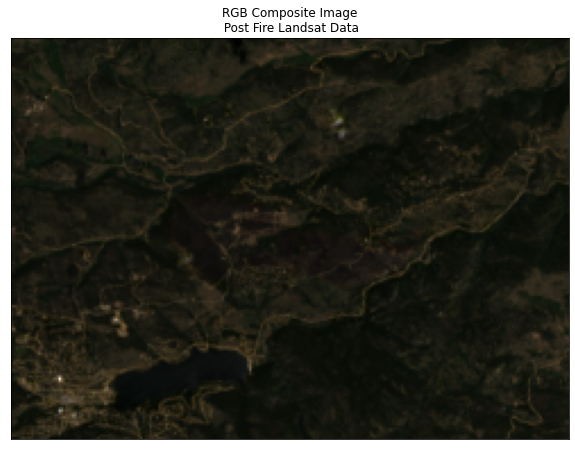

In [8]:
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[3, 2, 1],
            title="RGB Composite Image\n Post Fire Landsat Data")
plt.show()

Notice that the image above looks dark. You can stretch the image as you did with the NAIP data, too.
Below you use the stretch argument built into the earthpy `plot_rgb()` function. The `str_clip` argument allows you to specify how much of the tails of the data that you want to clip off. The larger the number, the most the data will be stretched or brightened.

<figure>
    <a href="{{ site.url }}/images/earth-analytics/raster-data/raster-image-stretch-dark.jpg">
    <img src="{{ site.url }}/images/earth-analytics/raster-data/raster-image-stretch-dark.jpg" alt="When the range of pixel brightness values is closer to 0, a
    darker image is rendered by default. You can stretch the values to extend to
    the full 0-255 range of potential values to increase the visual contrast of
    the image.">
    </a>
    <figcaption>When the range of pixel brightness values is closer to 0, a
    darker image is rendered by default. You can stretch the values to extend to
    the full 0-255 range of potential values to increase the visual contrast of
    the image.
    </figcaption>
</figure>

<figure>
    <a href="{{ site.url }}/images/earth-analytics/raster-data/raster-image-stretch-light.jpg">
    <img src="{{ site.url }}/images/earth-analytics/raster-data/raster-image-stretch-light.jpg" alt="When the range of pixel brightness values is closer to 255, a
    lighter image is rendered by default. You can stretch the values to extend to
    the full 0-255 range of potential values to increase the visual contrast of
    the image.">
    </a>
    <figcaption>When the range of pixel brightness values is closer to 255, a
    lighter image is rendered by default. You can stretch the values to extend to
    the full 0-255 range of potential values to increase the visual contrast of
    the image.
    </figcaption>
</figure>

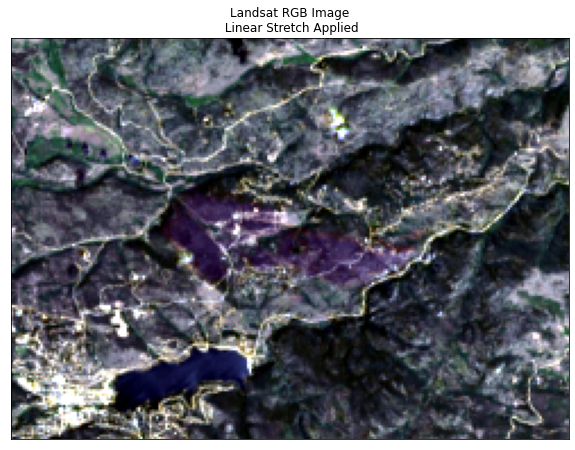

In [9]:
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[3, 2, 1],
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=1)
plt.show()

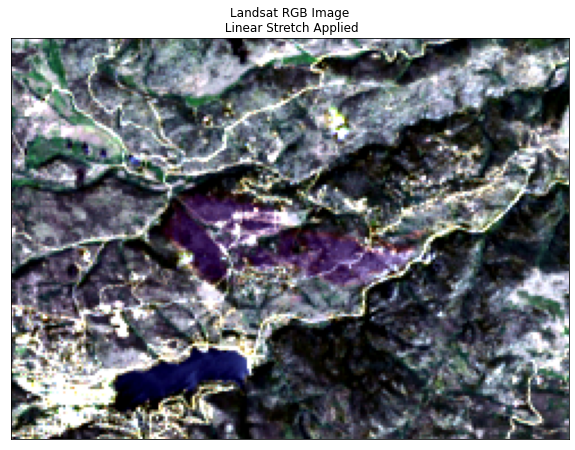

In [10]:
# Adjust the amount of linear stretch to futher brighten the image
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[3, 2, 1],
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=4)
plt.show()

## Raster Pixel Histograms

You can create a histogram to view the distribution of pixel values in the rgb bands plotted above. 

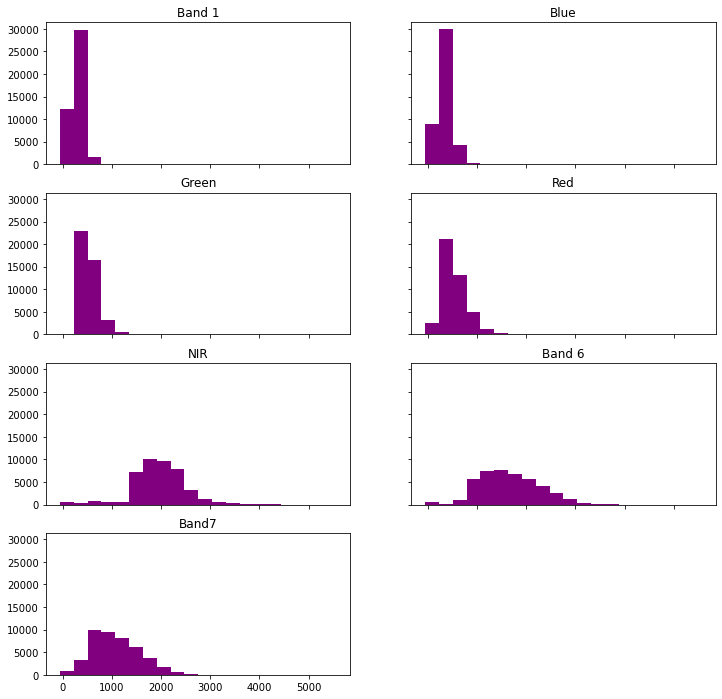

In [11]:
# Plot all band histograms using earthpy
band_titles = ["Band 1", 
               "Blue", 
               "Green", 
               "Red",
               "NIR", 
               "Band 6", 
               "Band7"]

ep.hist(landsat_post_fire_xr.values,
        title=band_titles)

plt.show()

In [12]:
# rgb_bands = landsat_post_fire[[3, 2, 1]]
# # plot histogram of each band
# colors = ['r', 'g', 'b']
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
# for band, color, ax in zip(rgb_bands, colors, axs.ravel()):
#     ax.hist(band.ravel(), bins=20, color=color, alpha=.8)

### Plot CIR

Now you've created a red, green blue color composite image. Remember red green and blue are colors that
your eye can see. 

Next, create a color infrared image (CIR) using landsat bands: 4,3,2.

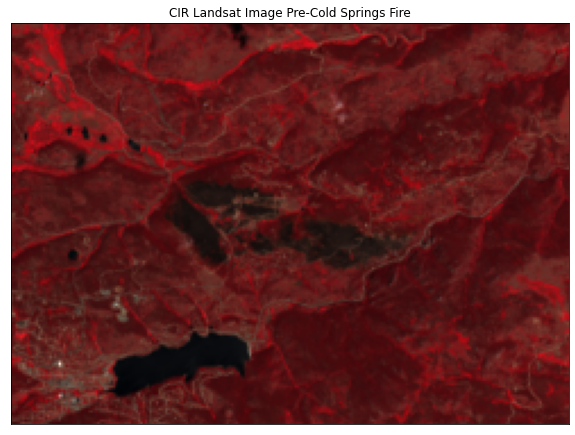

In [13]:
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[4, 3, 2],
            title="CIR Landsat Image Pre-Cold Springs Fire",
            figsize=(10, 10))
plt.show()

<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** Landsat 8 Pre Collections Data

If you are working with Landsat data downloaded pre USGS collections, your data may be formatted and named slightly differently than the example shown on this page. Below is an explanation of the legacy Landsat 8 naming convention. 

File: `LC08_L1TP_034032_20160707_20170221_01_T1_sr_band1_crop.tif`

| Sensor | Sensor | Satellite | WRS path | WRS row | | | | |
|-------|
| L | C | 8 | 034| 032| 2016 |0707 | 20170221 | 01 |
| Landsat | OLI & TIRS | Landsat 8 | path = 034 | row = 032 | year = 2016 | Month = 7, day = 7 | Processing Date: 2017-02-21 (feb 21 2017) | Archive (second version): 01 |

* L: Landsat
* X: Sensor
  * C = OLI & TIRS
    O = OLI only
    T = IRS only
    E = ETM+
    T = TM
    M = MSS

* S Satelite
* PPP
* RRR
* YYYY = Year
* DDD = Julian DAY of the year
* GSI - Ground station ID
* VV = Archive Version

<a href="http://gisgeography.com/landsat-file-naming-convention/" target="_blank"> More here breaking down the file name.</a>
</div>

## Julian day

We won't spend a lot of time on Julian days. The julian day used to be used in Landsat pre collections file naming. However recently they have switched to a normal year-month-date format

See this link that provide tables to help you <a href="https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html" target="_blank">convert julian days to actual date</a>.